### Практическое задание

1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df = pd.read_csv('airline-passengers.csv', parse_dates=['Month'], index_col=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


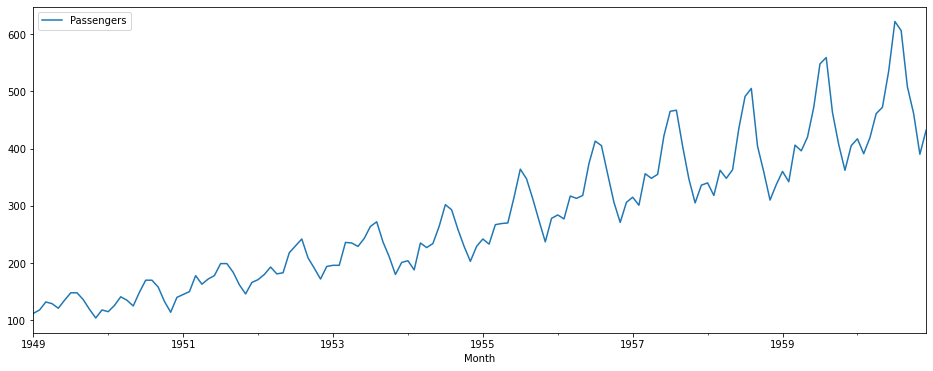

In [3]:
df.plot(figsize=(16, 6))
plt.show()

Подготовка данных

In [4]:
# добавляем столбец 'month'
df['year'] = df.index.year
df['month'] = df.index.month

print(df.shape)
df.head()

(144, 3)


,Passengers,year,month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5


In [5]:
split = 100

train = df[:split]
test = df[split:]

X_train = train.iloc[:,-2:]
y_train = train['Passengers']

X_test = test.iloc[:,-2:]
y_test = test['Passengers']

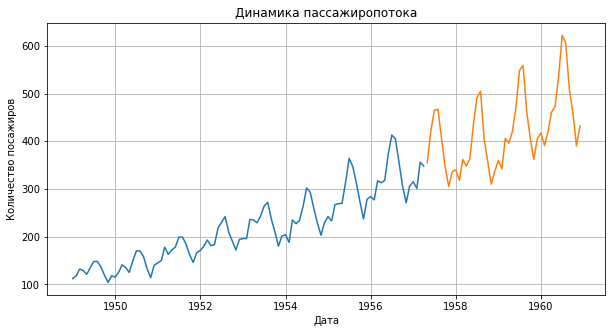

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Количество посажиров')
plt.title('Динамика пассажиропотока')
plt.show()

In [7]:
dataset_train = timeseries_dataset_from_array(
    X_train, y_train,
    sequence_length=3,
    sampling_rate=1,
    batch_size=32
)
dataset_test = timeseries_dataset_from_array(
    X_test, y_test,
    sequence_length=3,
    sampling_rate=1,
    batch_size=32
)

In [8]:
for batch in dataset_train.take(2):
  inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 2)
Target shape: (32,)


Проверим как влияет количество нейронов на ошибку.

Число нейронов 1, mse:
	Train: 50112.22265625
	Test: 180701.09375
Число нейронов 2, mse:
	Train: 49196.97265625
	Test: 178892.03125
Число нейронов 4, mse:
	Train: 47714.30078125
	Test: 175941.46875
Число нейронов 8, mse:
	Train: 44084.61328125
	Test: 168606.40625
Число нейронов 16, mse:
	Train: 38660.99609375
	Test: 157307.28125
Число нейронов 32, mse:
	Train: 15469.513671875
	Test: 100523.359375
Число нейронов 64, mse:
	Train: 6477.3623046875
	Test: 64543.21875
Число нейронов 128, mse:
	Train: 7119.9208984375
	Test: 32344.875


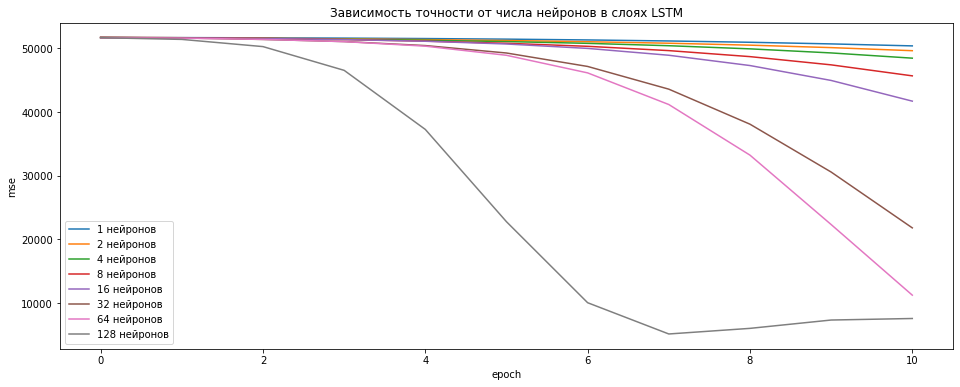

In [9]:
callback = EarlyStopping(monitor='val_mse', patience=5)

epochs = 10

plt.figure(figsize=(16, 6))

for kernels in (1, 2, 4, 8, 16, 32, 64, 128):

  model = Sequential([
      LSTM(kernels, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(kernels, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

  model.compile(loss="mse", 
                optimizer="nadam", 
                metrics=['mse'])

  hh0_train = model.evaluate(dataset_train, verbose=0)

  hh_train = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_test,
      callbacks=[callback], 
      verbose=0
  )

  hh1_train = model.evaluate(dataset_train, verbose=0)
  hh_test = model.evaluate(dataset_test, verbose=0)

  print(f"Число нейронов {kernels}, mse:")
  print(f"\tTrain: {hh1_train[1]}")
  print(f"\tTest: {hh_test[1]}")

  plt.plot(range(epochs+1), [hh0_train[0]] + hh_train.history['loss'], label=f'{kernels} нейронов')

plt.legend()
plt.title('Зависимость точности от числа нейронов в слоях LSTM')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

Вывод: увеличение числа нейронров улучшает точность нейросети. Однако при увеличении числа до 128 и выше, нейросеть переобучается и ошибка начинает возрастать. При количестве эпох 10 минимальная ошибка получается при количестве ядер = 64. В дальнейшем возьмем это количество нейронов за основу.

Поэксперементируем с числом нейронов в слое Conv1D.

Число нейронов 1, mse:
	Train: 46100.18359375
	Test: 172699.9375
Число нейронов 2, mse:
	Train: 39856.66015625
	Test: 159836.921875
Число нейронов 4, mse:
	Train: 37716.01171875
	Test: 155291.03125
Число нейронов 8, mse:
	Train: 28224.302734375
	Test: 134029.015625
Число нейронов 16, mse:
	Train: 14716.0458984375
	Test: 98210.3046875
Число нейронов 32, mse:
	Train: 6066.802734375
	Test: 61547.69140625
Число нейронов 64, mse:
	Train: 6738.30029296875
	Test: 33851.875
Число нейронов 128, mse:
	Train: 7370.244140625
	Test: 31456.892578125


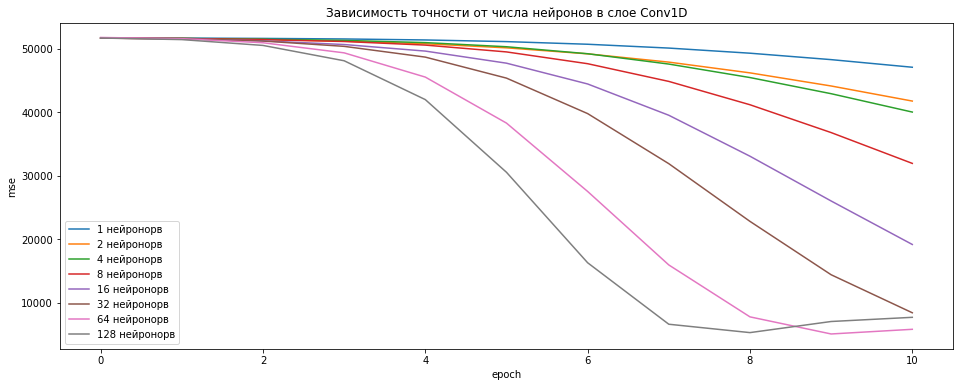

In [10]:
callback = EarlyStopping(monitor='val_mse', patience=5)

epochs = 10

plt.figure(figsize=(16, 6))

for kernels in (1, 2, 4, 8, 16, 32, 64, 128):

  model = Sequential([
      LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(64, return_sequences="True"),
      Conv1D(kernels, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

  model.compile(loss="mse", 
                optimizer="nadam", 
                metrics=['mse'])

  hh0_train = model.evaluate(dataset_train, verbose=0)

  hh_train = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_test,
      callbacks=[callback], 
      verbose=0
  )

  hh1_train = model.evaluate(dataset_train, verbose=0)
  hh_test = model.evaluate(dataset_test, verbose=0)

  print(f"Число нейронов {kernels}, mse:")
  print(f"\tTrain: {hh1_train[1]}")
  print(f"\tTest: {hh_test[1]}")

  plt.plot(range(epochs+1), [hh0_train[0]] + hh_train.history['loss'], label=f'{kernels} нейронорв')

plt.legend()
plt.title('Зависимость точности от числа нейронов в слое Conv1D')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

Вывод: как и в случае со слоями LSTM оптимальное количество нейронов в слое Conv1D = 64.

Теперь поэксперементируем со слоями.

In [11]:
model_1layer = Sequential([
      LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

model_2layers = Sequential([
      LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(64, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

model_3layers = Sequential([
      LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(64, return_sequences="True"),
      LSTM(64, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

model_4layers = Sequential([
      LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(64, return_sequences="True"),
      LSTM(64, return_sequences="True"),
      LSTM(64, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

Количество слоев 1, mse:
	Train: 22996.453125
	Test: 121251.9296875
Количество слоев 2, mse:
	Train: 6046.333984375
	Test: 37318.08984375
Количество слоев 3, mse:
	Train: 7150.83349609375
	Test: 32231.37890625
Количество слоев 4, mse:
	Train: 7266.24658203125
	Test: 31817.431640625


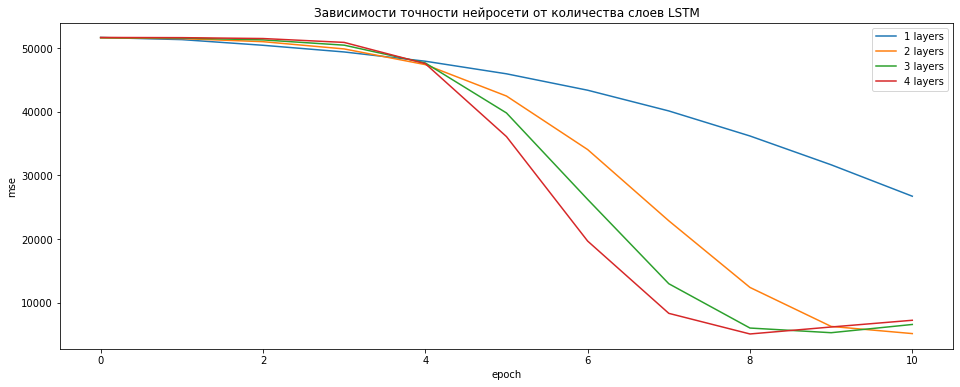

In [12]:
callback = EarlyStopping(monitor='val_mse', patience=5)

epochs = 10

plt.figure(figsize=(16, 6))

layers = 1
for model in (model_1layer, model_2layers, model_3layers, model_4layers):

  model.compile(loss="mse", 
                optimizer="nadam", 
                metrics=['mse'])

  hh0_train = model.evaluate(dataset_train, verbose=0)

  hh_train = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_test,
      callbacks=[callback], 
      verbose=0
  )

  hh1_train = model.evaluate(dataset_train, verbose=0)
  hh_test = model.evaluate(dataset_test, verbose=0)

  print(f"Количество слоев {layers}, mse:")
  print(f"\tTrain: {hh1_train[1]}")
  print(f"\tTest: {hh_test[1]}")

  plt.plot(range(epochs+1), [hh0_train[0]] + hh_train.history['loss'], label=f'{layers} layers')
  layers += 1  

plt.legend()
plt.title('Зависимости точности нейросети от количества слоев LSTM')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

Наилучший результат на тренировочной выборке показала модель с 2 слоями LSTM. На тестовой выборке лучший результат у сети с 3 слоями. Но на графике видно, что после 8 эпох происходит насыщение.

#### Вывод:
Улучшить результат помгло изменение следующих параметров:
- количества числа нейронов в слоях LSTM
- количества числа нейронов в Conv1D
- количество слоев LSTM
При этом следует отметить что во всех случаях, а также в случае изменеия числа эпох, происходит насыщение и затем переобучение модели.

Оптимальный результат получается:
- для тренировочной выборки: количество нейронов = 64, количество слоев LSTM = 2
- для тестовой выборки: количество нейронов = 64, количество слоев LSTM = 3